#**ASSIGNMENT 3**

In this assignment, our objective is to build a model to find similarities between films based on the interactions of the users, considering the dataset in a graph format.

The dataset contains all the views of users on items (films) and genres of each item: we decided not to consider the genres because of the small relations between the suggested films and their genres, and also to avoid the bubble effect (thinking about Netflix recommended film section).
To convert this dataset in a graph format, each film was converted into a node and an edge was built between each node, depending on the number of users that watched and evaluated both films with a grade higher than a threshold (we used a threshold of 5/5).

The idea is to build random paths on the graph considering the weights assigned and then train the model to predict the following node during a path. To make this, we built 2 different models: one considering only a node as input and one considering also some context nodes.

However, in both cases, we couldn’t reach a high accuracy: this is due to the fact that each film has many neighbors and has many “similar films”, but at each iteration only one is considered to be the correct result.
For this reason, we decided to add some evaluation metrics to see how much, effectively, the predictions are good.

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import torch.nn.init as init
import matplotlib.lines as mlines
from sklearn.decomposition import PCA

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

print(device)

cuda:0


In [3]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [4]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
movies.head(5)
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head(5)
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [5]:
# these function will be used to plot the movies and see the results
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [6]:
min_rating = 5

#dictionary that counts how many times a pair of movies have been evaluated 5 by the same user
pair_frequency = defaultdict(int)
#dictionary that counts how many times each film received evaluation 5
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
# this produces a list of tuples, where each tuple contains a userId and the subset of related_movies seen by that user and rated 5
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    # for each set of movies evaluated 5 seen by a user we build the item frequency dictionary
    # to count how many times that movie has been evaluated 5
    # then, given that the movies are ordered, for each movie in the list, we go trhough the movie in the following position
    # and we pair each of these, since they have been both evaluated 5 by the same user
    # these pairs are added to the pair frequency dictionary, counting how many times they have been rated 5 by the same user
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1


Compute movie rating frequencies: 100%|██████████| 573/573 [00:01<00:00, 293.83it/s]


In [7]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()

# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:01<00:00, 246171.09it/s]


In [8]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [9]:
vocabulary = ["NA"] + list(movies_graph.nodes) # NA to start from 1
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

##**TASK 1**

Here we build the walks and the training pair for the Skip-Gram model. In doing so, in the function random_walk, we base the next step on the weight of the edge that link two nodes (the higher the weight the higher the probability to take that step). p and q are two parameters used to regulate how much we let the model explore the graph or exploit the locality of the current node.

In [10]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]['weight']*(1/p))
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]['weight'])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]['weight']*(1/q))

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]

    return next

# we generate for each node a number of walks equal to num_walks, consisting of
# num_steps steps
def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [11]:
# To let the model explore the graph and don't get stuck in the locality of the node, we used p = 2 and q = 0.5
p = 2 # random walk return parameter.
q = .5 # random walk in-out parameter.

num_walks = 5 # number of iterations of random walks.
num_steps = 10 # number of steps of each random walk.

# Generating walks
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("\nNumber of steps generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:05<00:00, 247.41it/s]


Number of steps generated: 7025


##**TASK 2**

Here we generate some samples for targets, contexts, labels and weights and we put these samples in a DataLoader that can be used to train the Skip-Gram model.

We will train two different models, one taking into account the contexts and the other not.

For the latter (the No-Context Model), we build pairs, consisting in a node, which will be used as input, and a node which will be the label. The label node is the successive node in the walk. Basically each node in a walk will be used as input and the following one will be used as label. This can also be interpreted as using a window_size of length 0 to elaborate the walks (considering so zero nodes before the input node and zero nodes after the input label).

For the former (the Context Model), we increase the complexity by increasing the window_size, so adding new information to the input. Since we want every input node to have the same number of context nodes, for each walk we will not be able to use every node as input node (the nodes at the beginning and at the end of the walk wouldn't have the same number of context nodes, according to the window_size).

In [12]:
def generate_examples(walks, graph, window_size=2):
    window_size = window_size // 2  # we consider a number of window_size/2 at the left of the input node and window_size/2 at the right of the label node

    targets = [] # input nodes
    contexts = []
    labels = []
    weights = []

    for walk in walks:
        for i in range(window_size, len(walk) - window_size - 1): # we exclude the nodes that don't have (window_size) number of consecutive or precedent nodes
            # extracting input nodes and label nodes
            target = walk[i]
            label = walk[i + 1]

            targets.append(target)
            labels.append(label)
            weights.append(graph[vocabulary[target]][vocabulary[label]]['weight'])


            start_index = i - window_size # first node of the contexts
            end_index = i + 1 + window_size # last node of the contexts
            context_indices =  list(range(start_index, i)) + list(range(i + 2, end_index + 1)) # all contexts
            context = [walk[j] for j in context_indices] # extracting contexts

            contexts.append(context)

    targets = np.array(targets)
    contexts = np.array(contexts)
    labels = np.array(labels)
    weights = np.array(weights)

    maxim = max(weights)
    weights = weights/maxim # normalizing the weights value

    return targets, contexts, labels, weights

def create_dataset(inputs, contexts, labels, weights, batch_size):
    # create one hot encoding
    inputs = np.eye(len(vocabulary_lookup))[inputs]
    contexts = np.eye(len(vocabulary_lookup))[contexts]

    # Converting inputs and labels in tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    contexts = torch.tensor(contexts, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    weights = torch.tensor(weights, dtype=torch.float32)

    # Splitting into test and training sets
    X_train, X_test, y_train, y_test, con_train, con_test, w_train, w_test = train_test_split(
        inputs, labels, contexts, weights, test_size=0.1, random_state=42
    )

    # Creating dataloaders
    train_dataset = DataLoader(TensorDataset(X_train, y_train, con_train, w_train), batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataset = DataLoader(TensorDataset(X_test, y_test, con_test, w_test), batch_size=batch_size, shuffle=False, drop_last=True)

    return train_dataset, test_dataset

In [13]:
# Model parameters
batch_size = 512
window_size = 2 # must be greater than a half of len(walk)

targets, contexts, labels, weights = generate_examples(walks, movies_graph, window_size)
train_dataset, test_dataset = create_dataset(targets, contexts, labels, weights, batch_size)

In [14]:
# check for coherence
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (49175,)
Contexts shape: (49175, 2)
Labels shape: (49175,)
Weights shape: (49175,)


##**TASK 3**

Here we define and train the two models.

Initially, We added the connection weights into the training by multiplying the loss with it. In this way, we expected the model to penalize more mistakes on important connections. However, we noticed that by a simple multiplication, node pairs with big weights would have been penalized both with high and low loss. For this reason, we chose to compute the loss as: $loss = 3^{k \cdot (loss-threshold)}\cdot weight$. In order to penalize the error we needed a threshold able to distinguish good and bad results. Empirically, our train loss was around 5, so we chose $threshold = 5$. Moreover, $k = 3$ is another parameter that regolate how strongly we penalize or reward the model.  

In our first attempts, in order to avoid a gradient explotion effect, we also added a gradient clipping, scaling the gradients in such a way that the $L_2$ norm of each parameter cannot be more then 1. Subsequently, we changed strategy and we opted to normalize the weights in the range $[0,1]$, dividing them by their maximum value, as done before in the function *generate_examples*.


In [15]:
# Function to plot the loss
def plot_loss_tt(train_loss, test_loss, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title("Train vs Test")
    plt.show()

### No-Context Model

In [16]:
# Model 1 (NO CONTEXTS)

dtype = torch.FloatTensor

class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()

        self.voc_size = voc_size
        self.embedding_size = embedding_size

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size > embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size > voc_size Weight

    def forward(self, input):
        hidden_layer = torch.matmul(input, self.W)
        output_layer = torch.matmul(hidden_layer, self.V)

        return output_layer # Softmax is already included in CrossEntropyLoss()

In [18]:
print(len(vocabulary))

1406


  2%|▎         | 10/400 [00:12<07:05,  1.09s/it]


Epoch: 0010, Train Cost = 7.271675, Weighted Cost = 134.758434
             Test Cost  = 7.318338, Weighted Cost = 154.150879



  5%|▌         | 20/400 [00:23<07:12,  1.14s/it]


Epoch: 0020, Train Cost = 7.113484, Weighted Cost = 80.099037
             Test Cost  = 7.192507, Weighted Cost = 101.916501



  8%|▊         | 30/400 [00:34<07:02,  1.14s/it]


Epoch: 0030, Train Cost = 6.884470, Weighted Cost = 37.676763
             Test Cost  = 6.994414, Weighted Cost = 53.104739



 10%|█         | 40/400 [00:45<07:12,  1.20s/it]


Epoch: 0040, Train Cost = 6.691526, Weighted Cost = 19.972352
             Test Cost  = 6.826082, Weighted Cost = 30.503681



 12%|█▎        | 50/400 [00:56<07:19,  1.25s/it]


Epoch: 0050, Train Cost = 6.558911, Weighted Cost = 12.938482
             Test Cost  = 6.709638, Weighted Cost = 20.783154



 15%|█▌        | 60/400 [01:09<08:50,  1.56s/it]


Epoch: 0060, Train Cost = 6.462427, Weighted Cost = 9.407883
             Test Cost  = 6.627046, Weighted Cost = 15.827758



 18%|█▊        | 70/400 [01:19<05:57,  1.08s/it]


Epoch: 0070, Train Cost = 6.388927, Weighted Cost = 7.384724
             Test Cost  = 6.564018, Weighted Cost = 12.855239



 20%|██        | 80/400 [01:30<05:37,  1.05s/it]


Epoch: 0080, Train Cost = 6.324290, Weighted Cost = 5.978549
             Test Cost  = 6.509864, Weighted Cost = 10.750165



 22%|██▎       | 90/400 [01:41<05:28,  1.06s/it]


Epoch: 0090, Train Cost = 6.261017, Weighted Cost = 4.877734
             Test Cost  = 6.457891, Weighted Cost = 9.054301



 25%|██▌       | 100/400 [01:53<05:21,  1.07s/it]


Epoch: 0100, Train Cost = 6.197984, Weighted Cost = 3.951684
             Test Cost  = 6.406074, Weighted Cost = 7.630127



 28%|██▊       | 110/400 [02:04<05:02,  1.04s/it]


Epoch: 0110, Train Cost = 6.136721, Weighted Cost = 3.226975
             Test Cost  = 6.355458, Weighted Cost = 6.456153



 30%|███       | 120/400 [02:15<05:22,  1.15s/it]


Epoch: 0120, Train Cost = 6.080947, Weighted Cost = 2.688773
             Test Cost  = 6.308791, Weighted Cost = 5.535626



 32%|███▎      | 130/400 [02:27<05:41,  1.27s/it]


Epoch: 0130, Train Cost = 6.029827, Weighted Cost = 2.267316
             Test Cost  = 6.267342, Weighted Cost = 4.828661



 35%|███▌      | 140/400 [02:37<04:35,  1.06s/it]


Epoch: 0140, Train Cost = 5.983113, Weighted Cost = 1.957630
             Test Cost  = 6.230150, Weighted Cost = 4.271685



 38%|███▊      | 150/400 [02:48<04:10,  1.00s/it]


Epoch: 0150, Train Cost = 5.943573, Weighted Cost = 1.710871
             Test Cost  = 6.196900, Weighted Cost = 3.828087



 40%|████      | 160/400 [03:00<04:18,  1.08s/it]


Epoch: 0160, Train Cost = 5.907828, Weighted Cost = 1.524160
             Test Cost  = 6.168090, Weighted Cost = 3.481682



 42%|████▎     | 170/400 [03:13<04:08,  1.08s/it]


Epoch: 0170, Train Cost = 5.876975, Weighted Cost = 1.371800
             Test Cost  = 6.142877, Weighted Cost = 3.204564



 45%|████▌     | 180/400 [03:24<03:52,  1.06s/it]


Epoch: 0180, Train Cost = 5.848907, Weighted Cost = 1.253490
             Test Cost  = 6.121670, Weighted Cost = 2.989259



 48%|████▊     | 190/400 [03:35<03:44,  1.07s/it]


Epoch: 0190, Train Cost = 5.824846, Weighted Cost = 1.159880
             Test Cost  = 6.103009, Weighted Cost = 2.812025



 50%|█████     | 200/400 [03:47<03:56,  1.18s/it]


Epoch: 0200, Train Cost = 5.804231, Weighted Cost = 1.083499
             Test Cost  = 6.087706, Weighted Cost = 2.675055



 52%|█████▎    | 210/400 [03:59<04:03,  1.28s/it]


Epoch: 0210, Train Cost = 5.785769, Weighted Cost = 1.017082
             Test Cost  = 6.074360, Weighted Cost = 2.561502



 55%|█████▌    | 220/400 [04:11<03:40,  1.23s/it]


Epoch: 0220, Train Cost = 5.770505, Weighted Cost = 0.969062
             Test Cost  = 6.062545, Weighted Cost = 2.464634



 57%|█████▊    | 230/400 [04:22<03:03,  1.08s/it]


Epoch: 0230, Train Cost = 5.755634, Weighted Cost = 0.922011
             Test Cost  = 6.052818, Weighted Cost = 2.388078



 60%|██████    | 240/400 [04:33<02:43,  1.02s/it]


Epoch: 0240, Train Cost = 5.743621, Weighted Cost = 0.883694
             Test Cost  = 6.044649, Weighted Cost = 2.326026



 62%|██████▎   | 250/400 [04:44<02:35,  1.04s/it]


Epoch: 0250, Train Cost = 5.732981, Weighted Cost = 0.861482
             Test Cost  = 6.037117, Weighted Cost = 2.270532



 65%|██████▌   | 260/400 [04:55<02:25,  1.04s/it]


Epoch: 0260, Train Cost = 5.722690, Weighted Cost = 0.826921
             Test Cost  = 6.031002, Weighted Cost = 2.226578



 68%|██████▊   | 270/400 [05:06<02:16,  1.05s/it]


Epoch: 0270, Train Cost = 5.714164, Weighted Cost = 0.805779
             Test Cost  = 6.025807, Weighted Cost = 2.190089



 70%|███████   | 280/400 [05:18<02:17,  1.14s/it]


Epoch: 0280, Train Cost = 5.706088, Weighted Cost = 0.788080
             Test Cost  = 6.020565, Weighted Cost = 2.153676



 72%|███████▎  | 290/400 [05:29<02:12,  1.21s/it]


Epoch: 0290, Train Cost = 5.699169, Weighted Cost = 0.766058
             Test Cost  = 6.016598, Weighted Cost = 2.126779



 75%|███████▌  | 300/400 [05:41<02:06,  1.26s/it]


Epoch: 0300, Train Cost = 5.691825, Weighted Cost = 0.752497
             Test Cost  = 6.013124, Weighted Cost = 2.104000



 78%|███████▊  | 310/400 [05:51<01:37,  1.08s/it]


Epoch: 0310, Train Cost = 5.686734, Weighted Cost = 0.735497
             Test Cost  = 6.010559, Weighted Cost = 2.087668



 80%|████████  | 320/400 [06:02<01:23,  1.05s/it]


Epoch: 0320, Train Cost = 5.681458, Weighted Cost = 0.726253
             Test Cost  = 6.008553, Weighted Cost = 2.074700



 82%|████████▎ | 330/400 [06:14<01:17,  1.11s/it]


Epoch: 0330, Train Cost = 5.676701, Weighted Cost = 0.710691
             Test Cost  = 6.006257, Weighted Cost = 2.060139



 85%|████████▌ | 340/400 [06:25<01:07,  1.13s/it]


Epoch: 0340, Train Cost = 5.671663, Weighted Cost = 0.699381
             Test Cost  = 6.004613, Weighted Cost = 2.050256



 88%|████████▊ | 350/400 [06:37<00:55,  1.11s/it]


Epoch: 0350, Train Cost = 5.666885, Weighted Cost = 0.687025
             Test Cost  = 6.003320, Weighted Cost = 2.042270



 90%|█████████ | 360/400 [06:48<00:47,  1.18s/it]


Epoch: 0360, Train Cost = 5.663420, Weighted Cost = 0.680102
             Test Cost  = 6.002594, Weighted Cost = 2.038926



 92%|█████████▎| 370/400 [07:00<00:36,  1.20s/it]


Epoch: 0370, Train Cost = 5.659326, Weighted Cost = 0.672195
             Test Cost  = 6.001746, Weighted Cost = 2.033823



 95%|█████████▌| 380/400 [07:12<00:26,  1.32s/it]


Epoch: 0380, Train Cost = 5.655966, Weighted Cost = 0.665993
             Test Cost  = 6.001794, Weighted Cost = 2.034806



 98%|█████████▊| 390/400 [07:23<00:12,  1.22s/it]


Epoch: 0390, Train Cost = 5.652636, Weighted Cost = 0.655890
             Test Cost  = 6.001918, Weighted Cost = 2.036470



100%|██████████| 400/400 [07:34<00:00,  1.14s/it]


Epoch: 0400, Train Cost = 5.649721, Weighted Cost = 0.651543
             Test Cost  = 6.001424, Weighted Cost = 2.033850



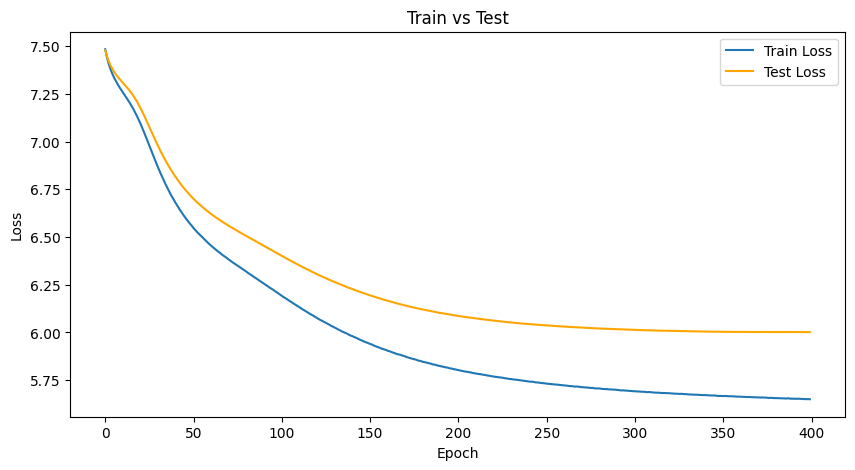

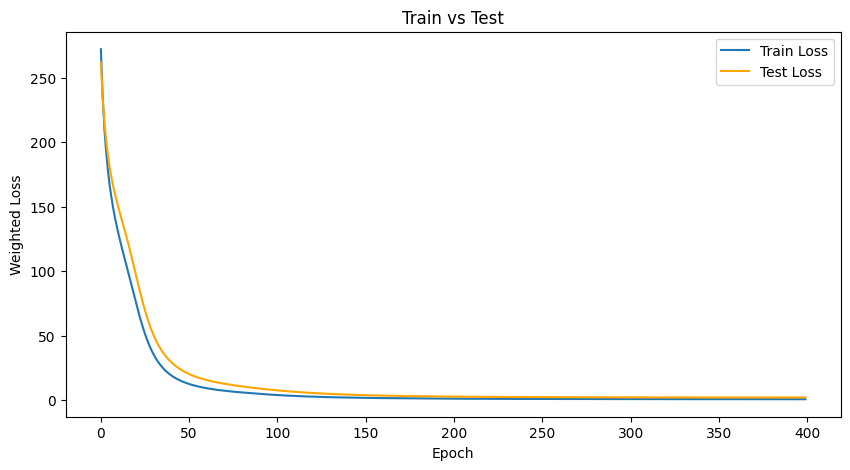

In [ ]:
# MODEL 1 (no contexts)

# Settings
voc_size = len(vocabulary)
embedding_size = 5

model1 = Word2Vec(voc_size, embedding_size)
model1 = model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5) # Evaluate whether the metric has improved. If there are no improvements for 5 consecutive epochs, the learning rate is reduced.

break_val = 30 # number of epochs after which the model stops if no improvements
n_lim = 0 # counter for no improvement epochs
best_loss = float('inf')
n_epochs = 400

# Lists initialization
train_loss_list = []
weighted_train_loss_list = []
test_loss_list = []
weighted_test_loss_list = []

# Train
for epoch in tqdm(range(n_epochs)):
    model1.train() # train mode on
    train_epoch_loss = 0
    train_epoch_weighted_loss = 0

    for input_batch, target_batch, _, weight_batch in train_dataset:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        weight_batch = weight_batch.to(device)

        output = model1(input_batch)

        loss = criterion(output, target_batch.long())
        weighted_loss = (3**(3*(loss-5)))*weight_batch # weighted loss adjustment (as explained above)

        loss = loss.mean()
        weighted_loss = weighted_loss.mean()

        optimizer.zero_grad()
        weighted_loss.backward()

        #torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0) # scaling the gradients in such a way that the L2 norm of each parameter cannot be more then 1

        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_weighted_loss += weighted_loss.item()

    train_loss_list.append(train_epoch_loss / len(train_dataset))
    weighted_train_loss_list.append(train_epoch_weighted_loss / len(train_dataset))
    #scheduler.step(train_epoch_weighted_loss / len(train_dataset))  # Update learning rate

    # Evaluation
    model1.eval()

    test_epoch_loss = 0
    weighted_test_epoch_loss = 0

    with torch.no_grad():
        for input_batch, target_batch, _, weight_batch in test_dataset:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            weight_batch = weight_batch.to(device)

            output = model1(input_batch)

            loss = criterion(output, target_batch.long())
            weighted_loss = (3**(3*(loss-5)))*weight_batch

            loss = loss.mean()
            weighted_loss = weighted_loss.mean()

            test_epoch_loss += loss.item()
            weighted_test_epoch_loss += weighted_loss.item()

    test_loss_list.append(test_epoch_loss / len(test_dataset))
    weighted_test_loss_list.append(weighted_test_epoch_loss / len(test_dataset))

    # Checking the improvement, stopping criterion
    if (weighted_test_loss_list[-1] < best_loss):
        best_loss = weighted_test_loss_list[-1]
        n_lim = 0
    else:
        n_lim += 1
        if (n_lim >= break_val):
            print(f"\nBreak due to overfitting, Train Cost = {train_loss_list[-1]:.6f}, Weighted Cost = {weighted_train_loss_list[-1]:.6f}")
            print(f'             Test Cost  = {test_loss_list[-1]:.6f}, Weighted Cost = {weighted_test_loss_list[-1]:.6f}\n')
            break

    # Evolution visualization
    if (epoch + 1) % 10 == 0:
        print(f'\nEpoch: {epoch + 1:04d}, Train Cost = {train_loss_list[-1]:.6f}, Weighted Cost = {weighted_train_loss_list[-1]:.6f}')
        print(f'             Test Cost  = {test_loss_list[-1]:.6f}, Weighted Cost = {weighted_test_loss_list[-1]:.6f}\n')

# Loss Plot
plot_loss_tt(train_loss_list, test_loss_list, 'Loss')
plot_loss_tt(weighted_train_loss_list, weighted_test_loss_list, 'Weighted Loss')

### Context Model

In [ ]:
# Model 2 (CONTEXTS)

dtype = torch.FloatTensor

class Word2Vec2(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec2, self).__init__()

        self.voc_size = voc_size

        self.embedding_size = embedding_size

        #self.dropout = nn.Dropout(p=0.5)

        # embedding of inputs
        self.W = nn.Parameter(init.xavier_uniform_(torch.empty(voc_size, embedding_size))).type(dtype)
        self.V = nn.Parameter(init.xavier_uniform_(torch.empty(embedding_size, voc_size))).type(dtype)

        self.linear = nn.Linear(voc_size, voc_size)

    def forward(self, X1, X2):

        # TARGET COMPONENT

        out1 = torch.matmul(X1, self.W)
        out1 = torch.matmul(out1, self.V)

        #out1 = self.linear(out1)
        #out1 = self.dropout(out1)

        # CONTEXTS COMPONENT

        out2 = torch.matmul(X2, self.W)
        out2 = torch.matmul(out2, self.V)

        out2 = out2.mean(dim=1)

        #out2 = self.linear(out2)
        #out2 = self.dropout(out2)

        # FINAL OUTPUT

        out = out1 + out2
        #out = self.linear(out)

        return out

  2%|▎         | 10/400 [00:18<08:52,  1.37s/it]


Epoch: 0010, Train Cost = 6.326127, Weighted Cost = 5.991898
             Test Cost  = 6.390430, Weighted Cost = 7.252278



  5%|▌         | 20/400 [00:31<07:31,  1.19s/it]


Epoch: 0020, Train Cost = 5.974155, Weighted Cost = 1.886593
             Test Cost  = 6.096518, Weighted Cost = 2.757186



  8%|▊         | 30/400 [00:44<07:43,  1.25s/it]


Epoch: 0030, Train Cost = 5.789155, Weighted Cost = 1.025938
             Test Cost  = 5.955230, Weighted Cost = 1.732536



 10%|█         | 40/400 [00:57<07:21,  1.23s/it]


Epoch: 0040, Train Cost = 5.629209, Weighted Cost = 0.607082
             Test Cost  = 5.841799, Weighted Cost = 1.192377



 12%|█▎        | 50/400 [01:10<07:15,  1.24s/it]


Epoch: 0050, Train Cost = 5.475068, Weighted Cost = 0.364673
             Test Cost  = 5.743611, Weighted Cost = 0.862666



 15%|█▌        | 60/400 [01:25<07:06,  1.25s/it]


Epoch: 0060, Train Cost = 5.330819, Weighted Cost = 0.226884
             Test Cost  = 5.661507, Weighted Cost = 0.658316



 18%|█▊        | 70/400 [01:39<06:54,  1.26s/it]


Epoch: 0070, Train Cost = 5.194618, Weighted Cost = 0.144988
             Test Cost  = 5.594295, Weighted Cost = 0.527757



 20%|██        | 80/400 [01:52<06:33,  1.23s/it]


Epoch: 0080, Train Cost = 5.063137, Weighted Cost = 0.093962
             Test Cost  = 5.539590, Weighted Cost = 0.440782



 22%|██▎       | 90/400 [02:04<06:00,  1.16s/it]


Epoch: 0090, Train Cost = 4.937128, Weighted Cost = 0.062145
             Test Cost  = 5.495435, Weighted Cost = 0.381054



 25%|██▌       | 100/400 [02:17<06:03,  1.21s/it]


Epoch: 0100, Train Cost = 4.815630, Weighted Cost = 0.041705
             Test Cost  = 5.461167, Weighted Cost = 0.340454



 28%|██▊       | 110/400 [02:30<05:43,  1.18s/it]


Epoch: 0110, Train Cost = 4.698485, Weighted Cost = 0.028298
             Test Cost  = 5.435558, Weighted Cost = 0.312913



 30%|███       | 120/400 [02:43<05:12,  1.12s/it]


Epoch: 0120, Train Cost = 4.584367, Weighted Cost = 0.019515
             Test Cost  = 5.417948, Weighted Cost = 0.295222



 32%|███▎      | 130/400 [02:56<05:41,  1.26s/it]


Epoch: 0130, Train Cost = 4.474445, Weighted Cost = 0.013577
             Test Cost  = 5.409256, Weighted Cost = 0.286891



 35%|███▌      | 140/400 [03:09<05:19,  1.23s/it]


Epoch: 0140, Train Cost = 4.369854, Weighted Cost = 0.009655
             Test Cost  = 5.407805, Weighted Cost = 0.285510



 38%|███▊      | 150/400 [03:22<05:23,  1.29s/it]


Epoch: 0150, Train Cost = 4.269619, Weighted Cost = 0.006902
             Test Cost  = 5.412871, Weighted Cost = 0.290318



 40%|████      | 160/400 [03:34<04:50,  1.21s/it]


Epoch: 0160, Train Cost = 4.173624, Weighted Cost = 0.005042
             Test Cost  = 5.425464, Weighted Cost = 0.302888



 42%|████▏     | 166/400 [03:44<05:15,  1.35s/it]



Break due to overfitting, 
Train Cost = 4.109430, Weighted Cost = 0.004126
             Test Cost  = 5.437122, Weighted Cost = 0.314674



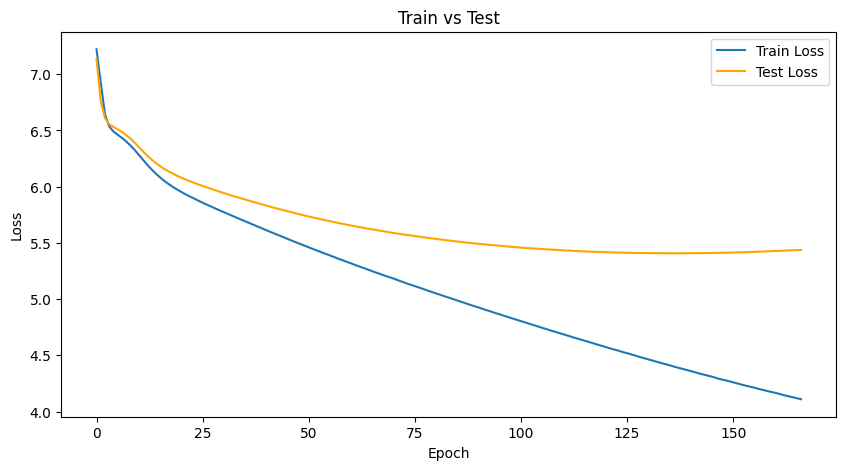

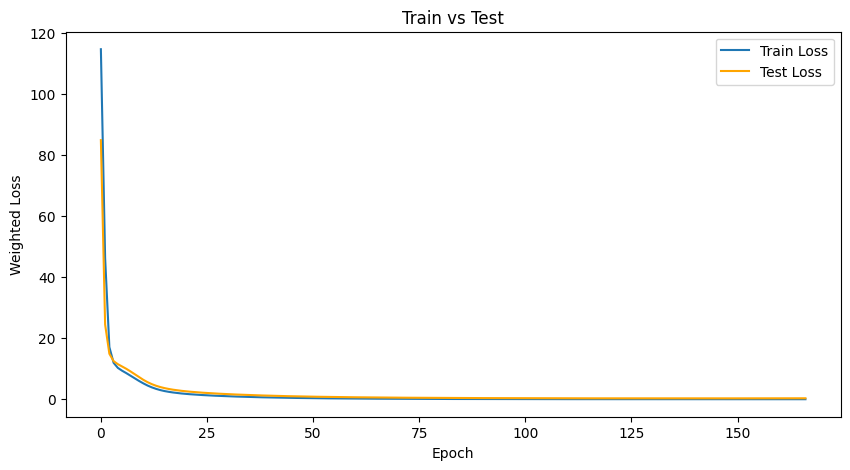

In [ ]:
# MODEL 2 (Context)

# Settings
voc_size = len(vocabulary)
embedding_size = 50


model2 = Word2Vec2(voc_size, embedding_size)
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5) # Evaluate whether the metric (in this case, weighted_test_epoch_loss) has improved. If there are no improvements for 5 consecutive epochs, the learning rate is reduced.

break_val = 30 # number of epochs after which the model stops if no improvement
n_lim = 0 # counter for no improvement epochs
best_loss = float('inf')
n_epochs = 400

# Lists initialization
train_loss_list = []
weighted_train_loss_list = []
test_loss_list = []
weighted_test_loss_list = []

# Train
for epoch in tqdm(range(n_epochs)):

    model2.train() # train mode on

    train_epoch_loss = 0
    train_epoch_weighted_loss = 0

    for input_batch, target_batch, context_batch, weight_batch in train_dataset:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        context_batch = context_batch.to(device)
        weight_batch = weight_batch.to(device)

        output = model2(input_batch, context_batch)

        loss = criterion(output, target_batch.long())
        weighted_loss = (3**(3*(loss-5)))*weight_batch # weighted loss adjustment

        loss = loss.mean()
        weighted_loss = weighted_loss.mean()

        optimizer.zero_grad()
        weighted_loss.backward()

        #torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0) # scaling the gradients in such a way that the L2 norm of each parameter cannot be more then 1

        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_weighted_loss += weighted_loss.item()

    train_loss_list.append(train_epoch_loss / len(train_dataset))
    weighted_train_loss_list.append(train_epoch_weighted_loss / len(train_dataset))
    #scheduler.step(train_epoch_weighted_loss / len(train_dataset))  # Update learning rate

    model2.eval() # evaluation mode on

    test_epoch_loss = 0
    weighted_test_epoch_loss = 0

    with torch.no_grad():
        for input_batch, target_batch, context_batch, weight_batch in test_dataset:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            context_batch = context_batch.to(device)
            weight_batch = weight_batch.to(device)

            output = model2(input_batch, context_batch)

            loss = criterion(output, target_batch.long())
            weighted_loss = (3**(3*(loss-5)))*weight_batch

            loss = loss.mean()
            weighted_loss = weighted_loss.mean()

            test_epoch_loss += loss.item()
            weighted_test_epoch_loss += weighted_loss.item()

    test_loss_list.append(test_epoch_loss / len(test_dataset))
    weighted_test_loss_list.append(weighted_test_epoch_loss / len(test_dataset))

    # Evolution visualization
    if (epoch + 1) % 10 == 0:
        print(f'\nEpoch: {epoch + 1:04d}, Train Cost = {train_loss_list[-1]:.6f}, Weighted Cost = {weighted_train_loss_list[-1]:.6f}')
        print(f'             Test Cost  = {test_loss_list[-1]:.6f}, Weighted Cost = {weighted_test_loss_list[-1]:.6f}\n')

    # Checking the improvement, stopping criterion
    if (weighted_test_loss_list[-1] < best_loss):
        best_loss = weighted_test_loss_list[-1]
        n_lim = 0
    else:
        n_lim += 1
        if (n_lim >= break_val):
            print(f"\n\nBreak due to overfitting, \nTrain Cost = {train_loss_list[-1]:.6f}, Weighted Cost = {weighted_train_loss_list[-1]:.6f}")
            print(f'             Test Cost  = {test_loss_list[-1]:.6f}, Weighted Cost = {weighted_test_loss_list[-1]:.6f}\n')
            break

# Plot Loss
plot_loss_tt(train_loss_list, test_loss_list, 'Loss')
plot_loss_tt(weighted_train_loss_list, weighted_test_loss_list, 'Weighted Loss')


### Consideration


Why does the loss stop decreasing and never reach zero? During the dataset construction for training and testing, we associate inputs and labels by traversing certain walks. However, given the length of the walks and their repetitiveness on each individual node, it will often happen that the desired output for the same input is different in each iteration. Consequently, even though the model learns the relationships between nodes, it will hardly be able to produce the desired label for that specific case.

### K-Fold Attempt

We tried to train the model making use of K-fold evaluation in order to check how it trains with different splits of the dataset. However, the results were the same of the previous ones.

In [ ]:
from sklearn.model_selection import KFold

def create_kfold_datasets(inputs, contexts, labels, weights, batch_size, k=5):

    inputs = np.eye(len(vocabulary_lookup))[inputs]
    contexts = np.eye(len(vocabulary_lookup))[contexts]

    # Converting inputs, labels, contexts, and weights to tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    contexts = torch.tensor(contexts, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    weights = torch.tensor(weights, dtype=torch.float32)

    maxim = max(weights)
    weights = weights/maxim # normalizing the weights value

    # Initialize k-fold cross-validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize lists to store datasets for each fold
    train_datasets = []
    val_datasets = []

    # Iterate through the folds
    for train_indices, val_indices in kf.split(inputs):
        X_train, y_train = inputs[train_indices], labels[train_indices]
        X_val, y_val = inputs[val_indices], labels[val_indices]
        con_train, con_val = contexts[train_indices], contexts[val_indices]
        w_train, w_val = weights[train_indices], weights[val_indices]

        # Create DataLoader for training and validation sets of the current fold
        train_dataset = DataLoader(TensorDataset(X_train, y_train, con_train, w_train),
                                   batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataset = DataLoader(TensorDataset(X_val, y_val, con_val, w_val),
                                 batch_size=batch_size, shuffle=False, drop_last=True)

        # Append datasets to the lists
        train_datasets.append(train_dataset)
        val_datasets.append(val_dataset)

    return train_datasets, val_datasets

# Creating datasets
train_datasets, val_datasets = create_kfold_datasets(targets, contexts, labels, weights, batch_size)

In [ ]:
# Settings
voc_size = len(vocabulary)
embedding_size = 4

break_val = 20 # number of epochs after which the model stops if no improvement
n_epochs = 200

cumulative_train_loss_list = []
cumulative_weighted_train_loss_list = []
cumulative_val_loss_list = []
cumulative_weighted_val_loss_list = []

# Train and validate the model on each fold
for fold in range(len(train_datasets)):

    model3 = Word2Vec2(voc_size, embedding_size)
    model3 = model3.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model3.parameters(), lr=0.001)
    #scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

    # Lists initialization
    train_loss_list = []
    weighted_train_loss_list = []
    val_loss_list = []
    weighted_val_loss_list = []

    print(f"\nFold {fold + 1}/{len(train_datasets)}")

    train_dataset = train_datasets[fold]
    val_dataset = val_datasets[fold]

    best_loss = float('inf')
    n_lim = 0  # counter for no improvement epochs
    early_stop = False

    for epoch in tqdm(range(n_epochs)):
        if early_stop:
            break

        # Train the model
        model3.train()
        train_epoch_loss = 0
        train_epoch_weighted_loss = 0

        for input_batch, target_batch, context_batch, weight_batch in train_dataset:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            context_batch = context_batch.to(device)
            weight_batch = weight_batch.to(device)

            output = model3(input_batch, context_batch)

            loss = criterion(output, target_batch.long())
            weighted_loss = 3**(3*(loss-5))*weight_batch # weighted loss adjustment (as explained above)

            loss = loss.mean()
            weighted_loss = weighted_loss.mean()

            optimizer.zero_grad()
            weighted_loss.backward()

            #torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_weighted_loss += weighted_loss.item()

        train_loss_list.append(train_epoch_loss / len(train_dataset))
        weighted_train_loss_list.append(train_epoch_weighted_loss / len(train_dataset))
        #scheduler.step()

        # Validate the model
        model3.eval()

        val_epoch_loss = 0
        val_epoch_weighted_loss = 0

        with torch.no_grad():
            for input_batch, target_batch, context_batch, weight_batch in val_dataset:
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)
                context_batch = context_batch.to(device)
                weight_batch = weight_batch.to(device)

                output = model3(input_batch, context_batch)

                loss = criterion(output, target_batch.long())
                weighted_loss = 3**(3*(loss-5))*weight_batch # weighted loss adjustment (as explained above)

                loss = loss.mean()
                weighted_loss = weighted_loss.mean()

                val_epoch_loss += loss.item()
                val_epoch_weighted_loss += weighted_loss.item()

        val_loss_list.append(val_epoch_loss / len(val_dataset))
        weighted_val_loss_list.append(val_epoch_weighted_loss / len(val_dataset))

        # Checking the improvement, stopping criterion
        if (weighted_val_loss_list[-1] < best_loss):
            best_loss = weighted_val_loss_list[-1]
            n_lim = 0
        else:
            n_lim += 1
            if (n_lim >= break_val):
                print(f"\n\nBreak due to overfitting in fold {fold + 1}, Epoch {epoch + 1}")
                print(f'Train Cost = {train_loss_list[-1]:.6f}, Weighted Cost = {weighted_train_loss_list[-1]:.6f}')
                print(f'Validation Cost  = {val_loss_list[-1]:.6f}, Weighted Cost = {weighted_val_loss_list[-1]:.6f}\n')
                early_stop = True

    # Accumulate the metrics of each fold in the cumulative lists
    cumulative_train_loss_list.append(np.mean(train_loss_list))
    cumulative_weighted_train_loss_list.append(np.mean(weighted_train_loss_list))
    cumulative_val_loss_list.append(np.mean(val_loss_list))
    cumulative_weighted_val_loss_list.append(np.mean(weighted_val_loss_list))

    # Plot the loss for the current fold
    plot_loss_tt(train_loss_list, val_loss_list, f'Fold {fold + 1} Training vs Validation Loss')
    plot_loss_tt(weighted_train_loss_list, weighted_val_loss_list, f'Fold {fold + 1} Weighted Training vs Validation Loss')

# Compute the mean of the metrics across all folds
mean_train_loss = np.mean(cumulative_train_loss_list)
mean_weighted_train_loss = np.mean(cumulative_weighted_train_loss_list)
mean_val_loss = np.mean(cumulative_val_loss_list)
mean_weighted_val_loss = np.mean(cumulative_weighted_val_loss_list)

print(f"Mean Training Loss: {mean_train_loss:.6f}")
print(f"Mean Weighted Training Loss: {mean_weighted_train_loss:.6f}")
print(f"Mean Validation Loss: {mean_val_loss:.6f}")
print(f"Mean Weighted Validation Loss: {mean_weighted_val_loss:.6f}")


##**TASK 4**

Given the list of movies provided, we build the embedding using the trained model and we visualize the results making use of PCA and t-SNE.

Moreover, we also provide a plot in which we evaluate how much the cosine similarity is able to interpret the model.

Finally, for each node $N_i$ in *query_movies*, we consider the $k$-top suggested movies $M_{ij}$ by the model. Then we compute the shortest path distance between $N_i$ and $M_{ij}$, comparing these results with the ones obtained with random nodes and random neighbors of $N_i$.

In [ ]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

### Functions

In [ ]:
def get_top_neighbors(graph, node, top_n): # given a node, return the top_n best neighbors based on the weight of the edge

    if node not in graph:
        raise ValueError(f"Node {node} not in graph!!!")
    neighbors = list(graph.neighbors(node))

    if not neighbors:
        return []
    sorted_neighbors = sorted(neighbors, key=lambda n: graph[node][n]['weight'], reverse=True)
    return sorted_neighbors[:top_n]

def find_node_position(graph, input_node, output_node): # given an input node and an output node, compute the position of the output node in the list generated by get_top_neighbors

    if input_node not in graph or output_node not in graph:
        return float('inf')
    top_neighbors = get_top_neighbors(graph, input_node, len(graph))

    if output_node not in top_neighbors:
        return 'not directly connected'
    position = top_neighbors.index(output_node) + 1

    return position


In [ ]:
def plot_similarities(similarity_matrix, k, highlight_indices, contexts=False, window_size=2):  # This function will be used to evaluate how much the cosine similarity is able to intepret the model
                                                                                                # More specifics on the rationale will be given in the call of the function afterwards
    # Checking correctness of indeces
    if not all(0 <= idx < similarity_matrix.shape[0] for idx in [k] + highlight_indices):
        raise ValueError("Index out of range!!!")

    # Get k-th row
    similarities = similarity_matrix[k-1]

    # Output computation

    inputs = np.eye(len(vocabulary_lookup))[k]
    inputs = torch.tensor(inputs,dtype=torch.float32 )
    inputs = inputs.to(device)

    if contexts:
        neighbors = list(movies_graph.neighbors(vocabulary[k]))
        neighbors = random.sample(neighbors, window_size)

        neighbors = [vocabulary_lookup[movie_id] for movie_id in neighbors]
        neighbors = np.array(neighbors)

        context = np.eye(len(vocabulary_lookup))[neighbors] # warning: to simplify the computations, we define the contexts as random neighbors
        context = torch.tensor(context, dtype=torch.float32)
        context = context.to(device)

        output = model2(inputs, context.unsqueeze(dim=0))
        output = output.argmax().item()

    else:
        output = model1(inputs)
        output = output.argmax().item()

    k -= 1

    # Compute similar nodes
    top_neighbors = get_top_neighbors(movies_graph, vocabulary[k] , top_n=10)


    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(similarities)), similarities)

    # Highlight the desired nodes
    for idx in highlight_indices:
        idx=idx-1
        plt.scatter(idx, similarities[idx], color='red', zorder=2)
        plt.text(idx, similarities[idx], f'{idx}', color='black', fontsize=10)
    for idx in top_neighbors:
      idx=vocabulary_lookup[idx]
      plt.scatter(idx, similarities[idx], color='pink',zorder=3)
      plt.text(idx, similarities[idx], f'{idx}', color='black', fontsize=10)


    plt.scatter(k, similarities[k], color='black', s=50, zorder=3)
    plt.text(k, similarities[k], f'{k}', color='black', fontsize=10)
    plt.scatter(output, similarities[output], color='orange', s=100, zorder=4)
    plt.text(output, similarities[output], f'{get_movie_title_by_id(vocabulary[output])}', color='black', fontsize=10)

    # Legend
    black_point = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label=f'{get_movie_title_by_id(vocabulary[k+1])}')
    red_point = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='Most similar embedding nodes')
    pink_point = mlines.Line2D([], [], color='pink', marker='o', linestyle='None', markersize=5, label='Top neighbors in graph')
    orange_point = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Model output')
    plt.legend(handles=[black_point, red_point, pink_point, orange_point])

    # Graphics
    plt.xlabel('Vector Index')
    plt.ylabel('Similarity')
    plt.title(f'Similarity of {get_movie_title_by_id(vocabulary[k+1])} with all other vectors')

    plt.grid(True)
    plt.show()

In [ ]:
# Helper function to get embedding by movie title
def get_embedding_by_title(title):
    movie_id = get_movie_id_by_title(title)
    return embedding_dict[movie_id]

# Helper function to find the top N most similar movies
def find_most_similar(movie_title, top_n=5):
    movie_id = get_movie_id_by_title(movie_title)
    idx = vocabulary_lookup[movie_id]-1

    # Get similarity scores
    similarities = similarity_matrix[idx]
    temp=similarities[idx]
    similarities[idx]=-1
    similar_indices = similarities.argsort()[-top_n:][::-1]
    similarities[idx]=temp

    similar_movies = [vocabulary[i + 1] for i in similar_indices]  # add 1 because we skipped 'NA'
    return [get_movie_title_by_id(movie_id) for movie_id in similar_movies]

### No-Context Model

In [ ]:
# Extract the embeddings

embeddings = model1.W.detach().cpu().numpy()
embedding_dict = {vocabulary[i]: embeddings[i] for i in range(len(vocabulary)) if i != 0}

# Get embeddings for query movies
query_embeddings = {title: get_embedding_by_title(title) for title in query_movies}

# Compute cosine similarity between all movie embeddings
all_embeddings = np.array(list(embedding_dict.values()))
similarity_matrix = cosine_similarity(all_embeddings) # here you can change "cosine_similarity" with Euclidean or Manhattan distances

# Get most similar movies for each query movie
most_similar_movies = {title: find_most_similar(title) for title in query_movies}

# Printing top-5 movies according to cosine similarity and the position based on the weight
for movie, similar_movies in most_similar_movies.items():
    print(f"Movies similar to '{movie}':")
    for sim_movie in similar_movies:
        print(f"  - {sim_movie} : {find_node_position(movies_graph, get_movie_id_by_title(movie), get_movie_id_by_title(sim_movie))}")


Movies similar to 'Matrix, The (1999)':
  - Zulu (1964) : not directly connected
  - Star Wars: Episode IV - A New Hope (1977) : 2
  - Master and Commander: The Far Side of the World (2003) : not directly connected
  - Green Mile, The (1999) : 57
  - Star Wars: Episode VI - Return of the Jedi (1983) : 6
Movies similar to 'Star Wars: Episode IV - A New Hope (1977)':
  - Fifth Element, The (1997) : 132
  - Matrix, The (1999) : 3
  - Wedding Singer, The (1998) : not directly connected
  - Saving Private Ryan (1998) : 10
  - Sixth Sense, The (1999) : 37
Movies similar to 'Lion King, The (1994)':
  - Aladdin (1992) : 2
  - Interview with the Vampire: The Vampire Chronicles (1994) : not directly connected
  - Casper (1995) : 66
  - Muppet Treasure Island (1996) : 153
  - I.Q. (1994) : 171
Movies similar to 'Terminator 2: Judgment Day (1991)':
  - Alien³ (a.k.a. Alien 3) (1992) : 329
  - Backdraft (1991) : 322
  - Enemy of the State (1998) : 250
  - Cape Fear (1991) : not directly connected
 

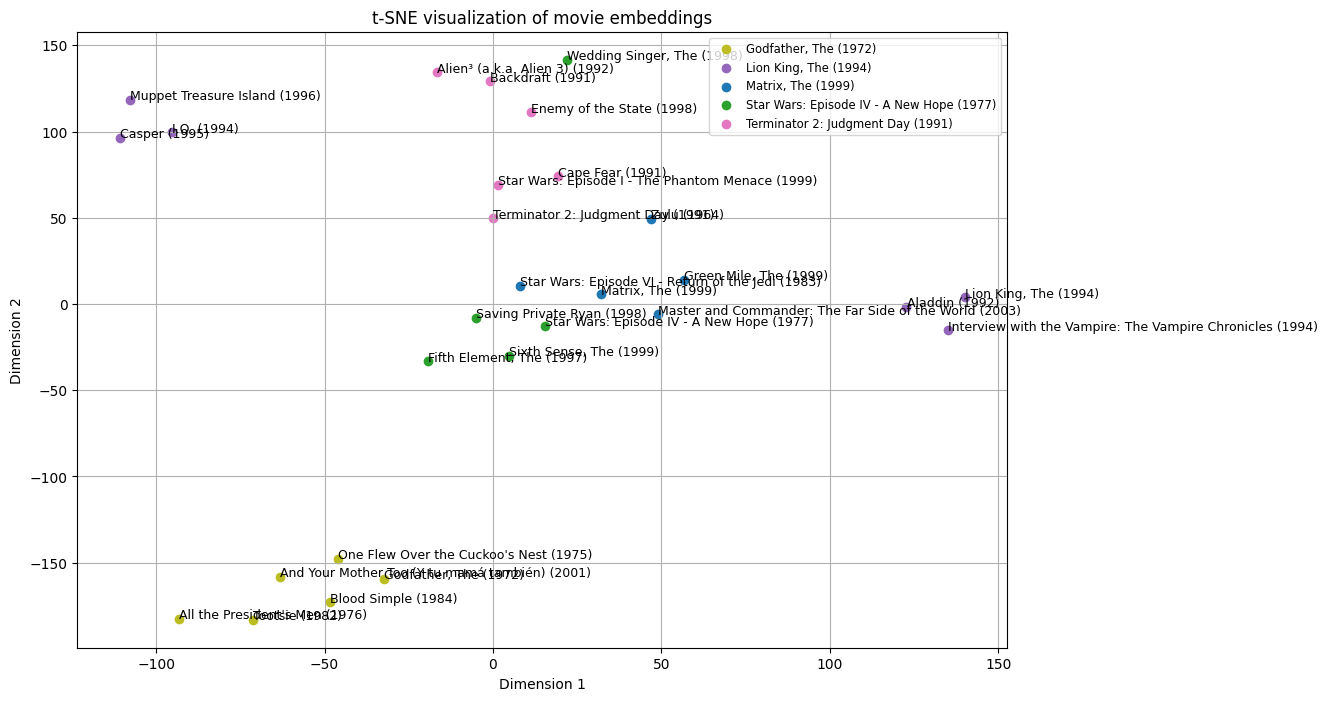

In [ ]:
############################## t-SNE ##########################################

# Get the embeddings for the movies of interest (query movies + similar movies)
movies_of_interest = list(query_embeddings.keys()) + [movie for similar in most_similar_movies.values() for movie in similar]
embeddings_of_interest = np.array([get_embedding_by_title(movie) for movie in movies_of_interest])

# Ensure there are no duplicate movies
movies_of_interest, idx = np.unique(movies_of_interest, return_index=True)
embeddings_of_interest = embeddings_of_interest[idx]

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Adjusted perplexity
reduced_embeddings = tsne.fit_transform(embeddings_of_interest)

# Create a DataFrame for visualization
embedding_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
embedding_df['title'] = movies_of_interest

# Assign colors to each similarity group
color_map = plt.get_cmap('tab10')
color_assignment = {}
group_counter = 0

for query in query_movies:
    color_assignment[query] = group_counter
    for similar_movie in most_similar_movies[query]:
        if similar_movie not in color_assignment:
            color_assignment[similar_movie] = group_counter
    group_counter += 1

# Add color information to the DataFrame
embedding_df['color'] = embedding_df['title'].map(color_assignment)

# Plot the embeddings with colors based on similarity groups
plt.figure(figsize=(12, 8))
for i, row in embedding_df.iterrows():
    plt.scatter(row['x'], row['y'], marker='o', color=color_map(row['color'] / group_counter), label=row['title'] if row['title'] in query_movies else "")
    plt.text(row['x'] + 0.02, row['y'] + 0.02, row['title'], fontsize=9)

# Create a custom legend for the query movies
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("t-SNE visualization of movie embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


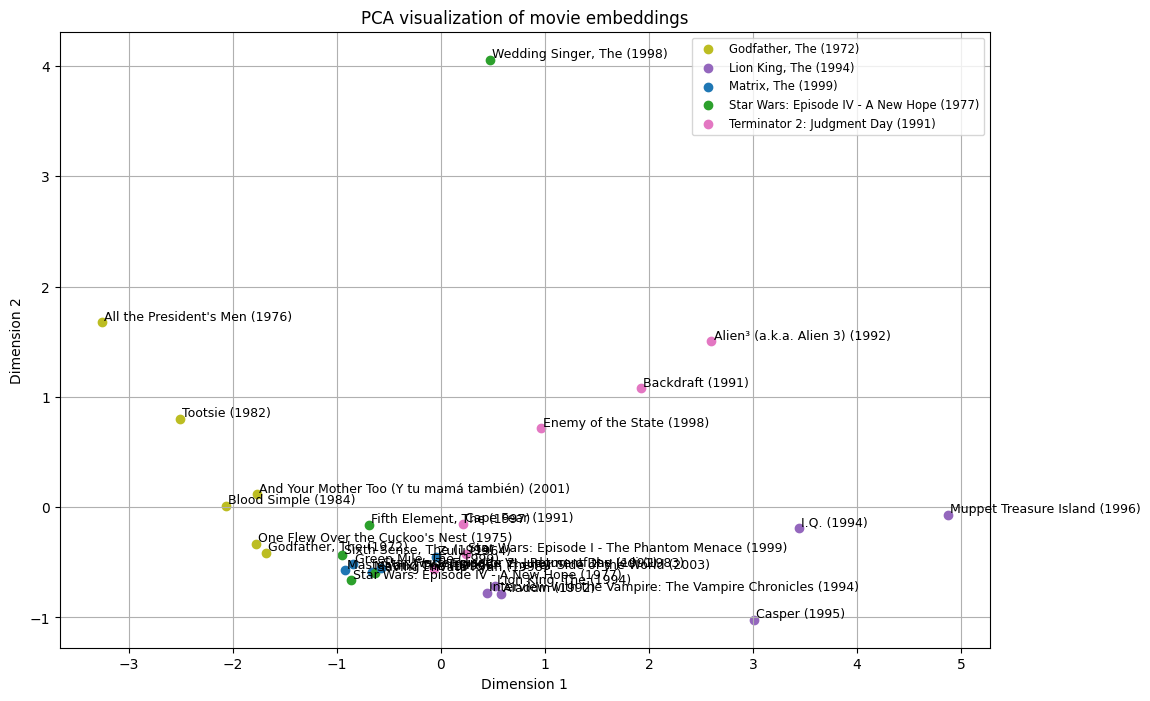

In [ ]:
############################ PCA ###############################################

#x = df.drop([0], axis=1)
x=embeddings_of_interest

pca = PCA(n_components=2)
new_data = pca.fit_transform(x)
new_data_df=pd.DataFrame(new_data,columns=['x', 'y'])

# Add color information to the DataFrame
new_data_df['title'] = movies_of_interest
new_data_df['color'] = new_data_df['title'].map(color_assignment)

plt.figure(figsize=(12, 8))
for i, row in new_data_df.iterrows():
    plt.scatter(row['x'], row['y'], marker='o', color=color_map(row['color'] / group_counter), label=row['title'] if row['title'] in query_movies else "")
    plt.text(row['x'] + 0.02, row['y'] + 0.02, row['title'], fontsize=9)

# Create a custom legend for the query movies
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("PCA visualization of movie embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

For both t-SNE and PCA, clusters are evident. The errors in the PCA are justified by the high dimensionality reduction applied.

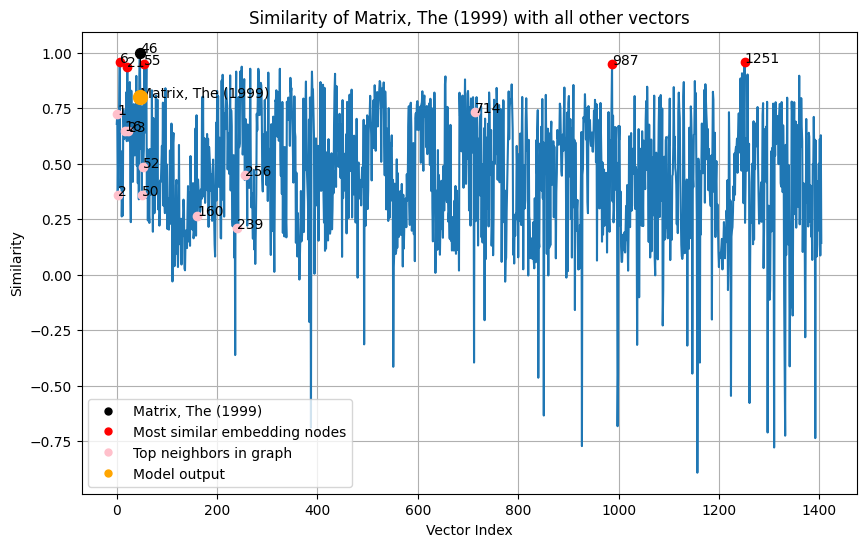

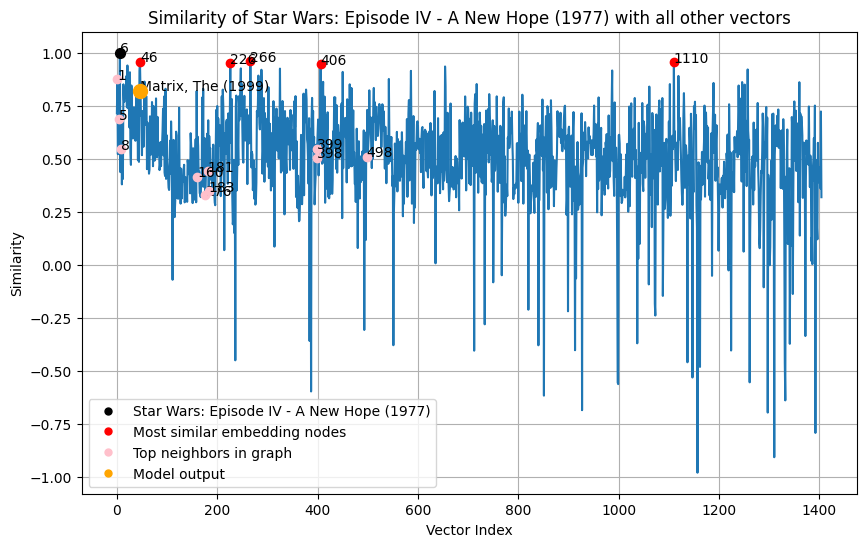

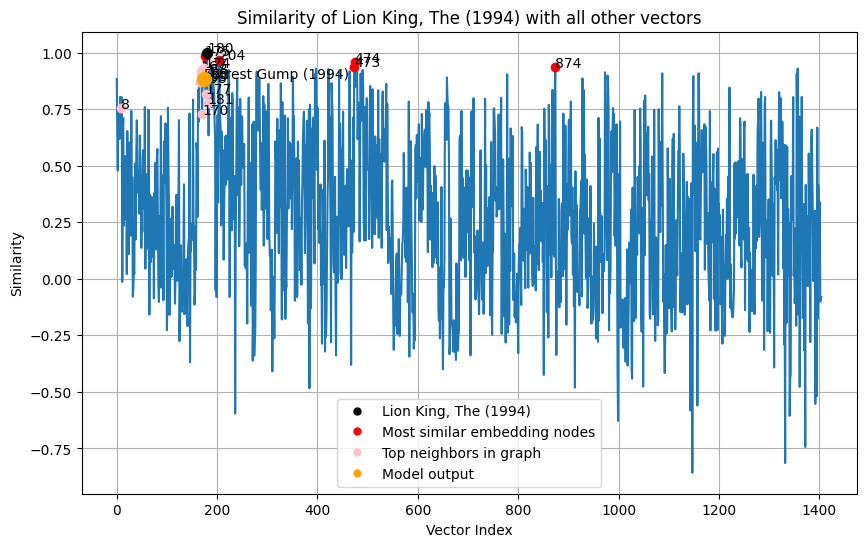

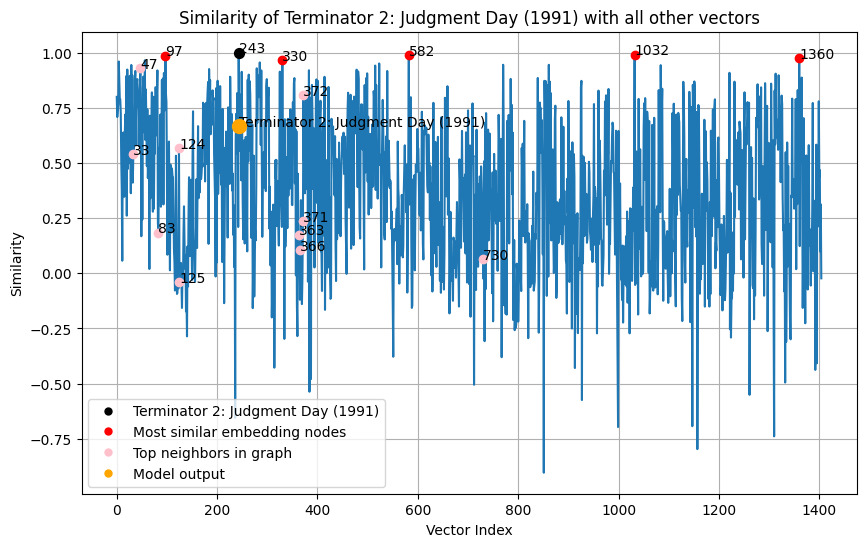

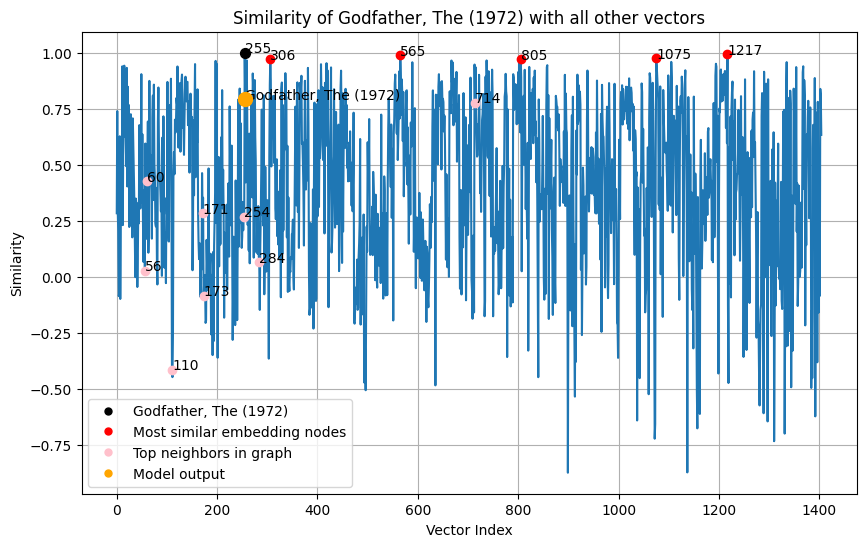

In [ ]:
################## SIMILARITY FUNCTION EVALUATION ##############################
'''
Here the goal is to compute and plot the cosine (or other) similarity of the embeddings of
the query movies wrt other nodes in order to deduce if this metric is able to
interpret the model or not. In particular, we highlight the cosine similarity
between the query movie and:
- the output of the model (in yellow)
- the nodes with the highest cosine similarity (in red)
- some of the neighours (in pink)
- the query movie itself (in black)
'''

for j in range(0,5):
  similar_movies_ids = [get_movie_id_by_title(idx) for idx in most_similar_movies[query_movies[j]]]
  vocabulary_ids = [vocabulary_lookup[idx] for idx in similar_movies_ids]
  plot_similarities(similarity_matrix,vocabulary_lookup[get_movie_id_by_title(query_movies[j])], vocabulary_ids)

Since the output of the model is never within the embeddings with the highest cosine similarity, we can conclude that the cosine similarity is not a metric able to completely interpret our model. Even though the output has high similarity, so does a huge amount of other nodes. As we will see, the results for the second model are even worse.

We cannot say anything about the validity of the model, since we do not know the metric the model exploit in order to interpret the embeddings and their relationship.

Afterwards, we will try another metric to infer and validate the rationale behind our model: the shortest path.

### Context Model

In [ ]:
# Extract the embeddings
embeddings = model2.W.detach().cpu().numpy()
embedding_dict = {vocabulary[i]: embeddings[i] for i in range(len(vocabulary)) if i != 0}

# Get embeddings for query movies
query_embeddings = {title: get_embedding_by_title(title) for title in query_movies}

# Compute cosine similarity between all movie embeddings
all_embeddings = np.array(list(embedding_dict.values()))
similarity_matrix = cosine_similarity(all_embeddings)

# Get most similar movies for each query movie
most_similar_movies = {title: find_most_similar(title) for title in query_movies}

# Printing top-5 movies according to cosine similarity and the position based on the weight
for movie, similar_movies in most_similar_movies.items():
    print(f"Movies similar to '{movie}':")
    for sim_movie in similar_movies:
        print(f"  - {sim_movie} : {find_node_position(movies_graph, get_movie_id_by_title(movie), get_movie_id_by_title(sim_movie))}")


Movies similar to 'Matrix, The (1999)':
  - Knight's Tale, A (2001) : not directly connected
  - Star Wars: Episode III - Revenge of the Sith (2005) : 251
  - Aristocrats, The (2005) : not directly connected
  - Bourne Ultimatum, The (2007) : 196
  - Moneyball (2011) : not directly connected
Movies similar to 'Star Wars: Episode IV - A New Hope (1977)':
  - Star Wars: Episode V - The Empire Strikes Back (1980) : 1
  - Nobody's Fool (1994) : not directly connected
  - E.T. the Extra-Terrestrial (1982) : 31
  - A.I. Artificial Intelligence (2001) : not directly connected
  - Star Wars: Episode II - Attack of the Clones (2002) : 227
Movies similar to 'Lion King, The (1994)':
  - Aladdin (1992) : 2
  - Now and Then (1995) : not directly connected
  - Wolf (1994) : not directly connected
  - Dave (1993) : 157
  - Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006) : not directly connected
Movies similar to 'Terminator 2: Judgment Day (1991)':
  - Bever

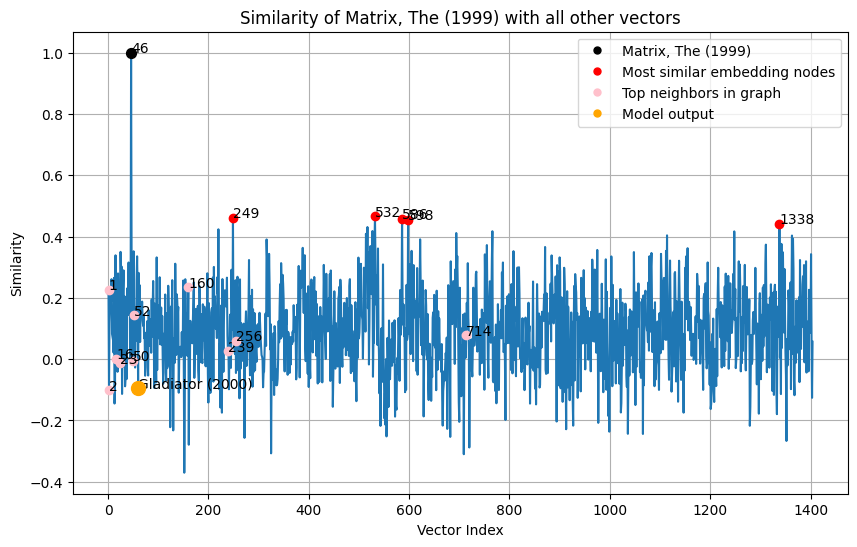

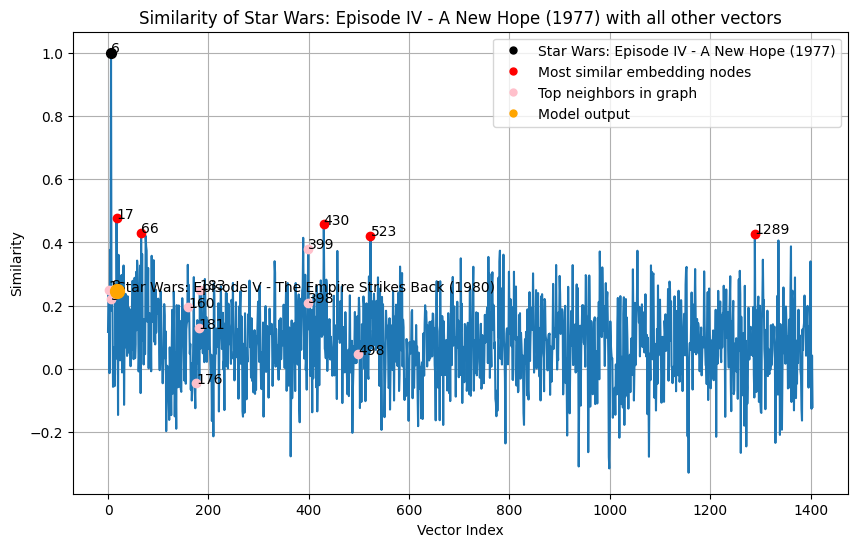

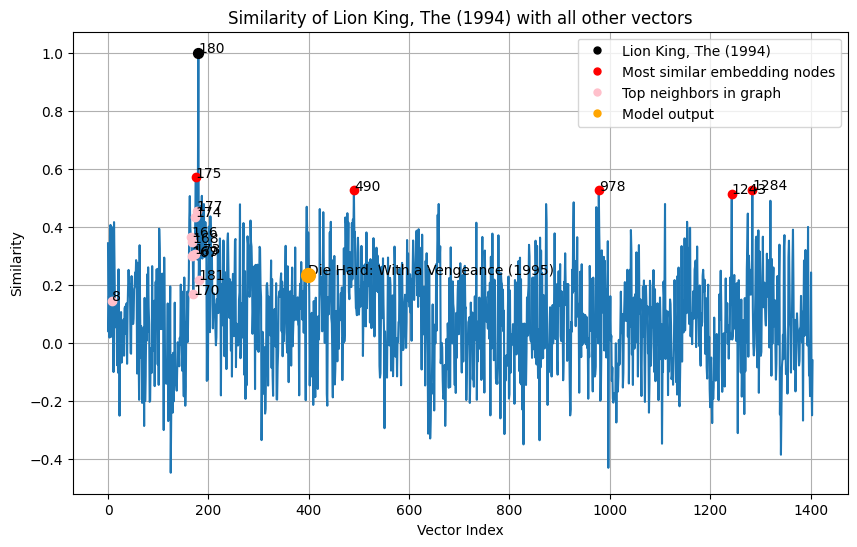

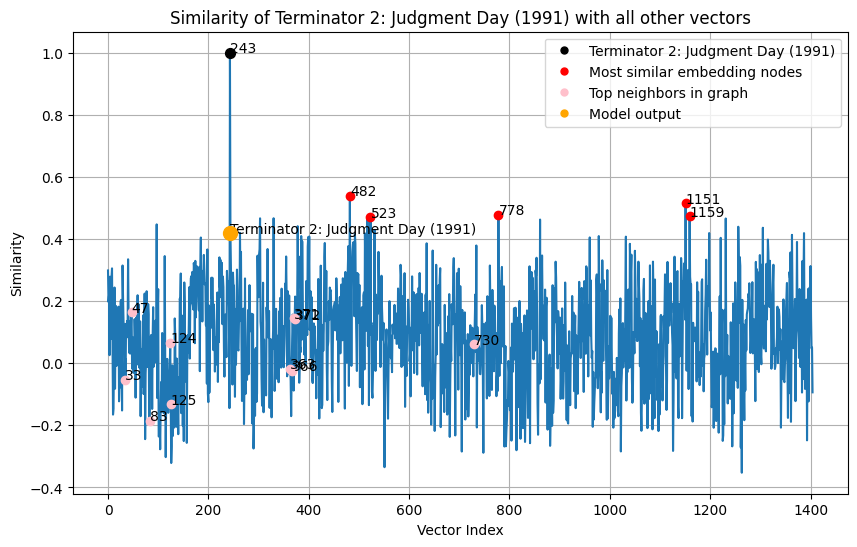

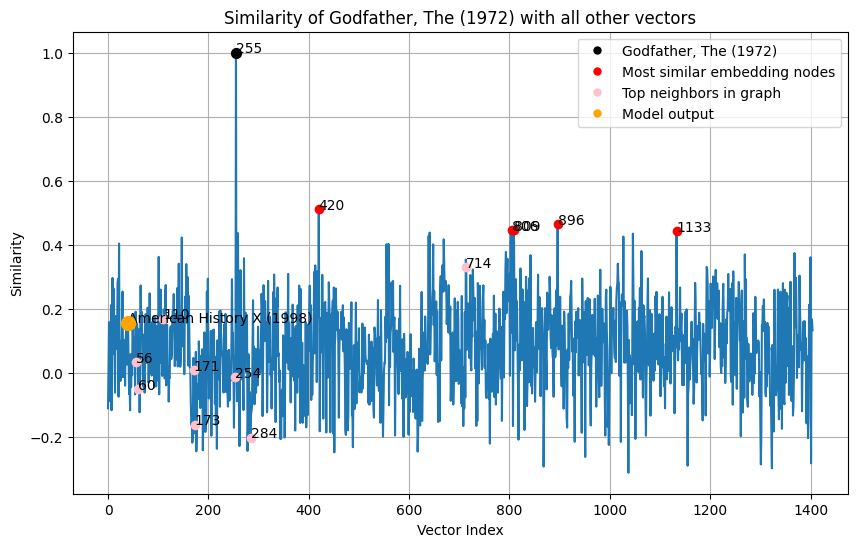

In [ ]:
################## SIMILARITY FUNCTION EVALUATION ##############################

for j in range(0,5):
  similar_movies_ids = [get_movie_id_by_title(idx) for idx in most_similar_movies[query_movies[j]]]
  vocabulary_ids = [vocabulary_lookup[idx] for idx in similar_movies_ids]
  plot_similarities(similarity_matrix,vocabulary_lookup[get_movie_id_by_title(query_movies[j])], vocabulary_ids,True, window_size=4)

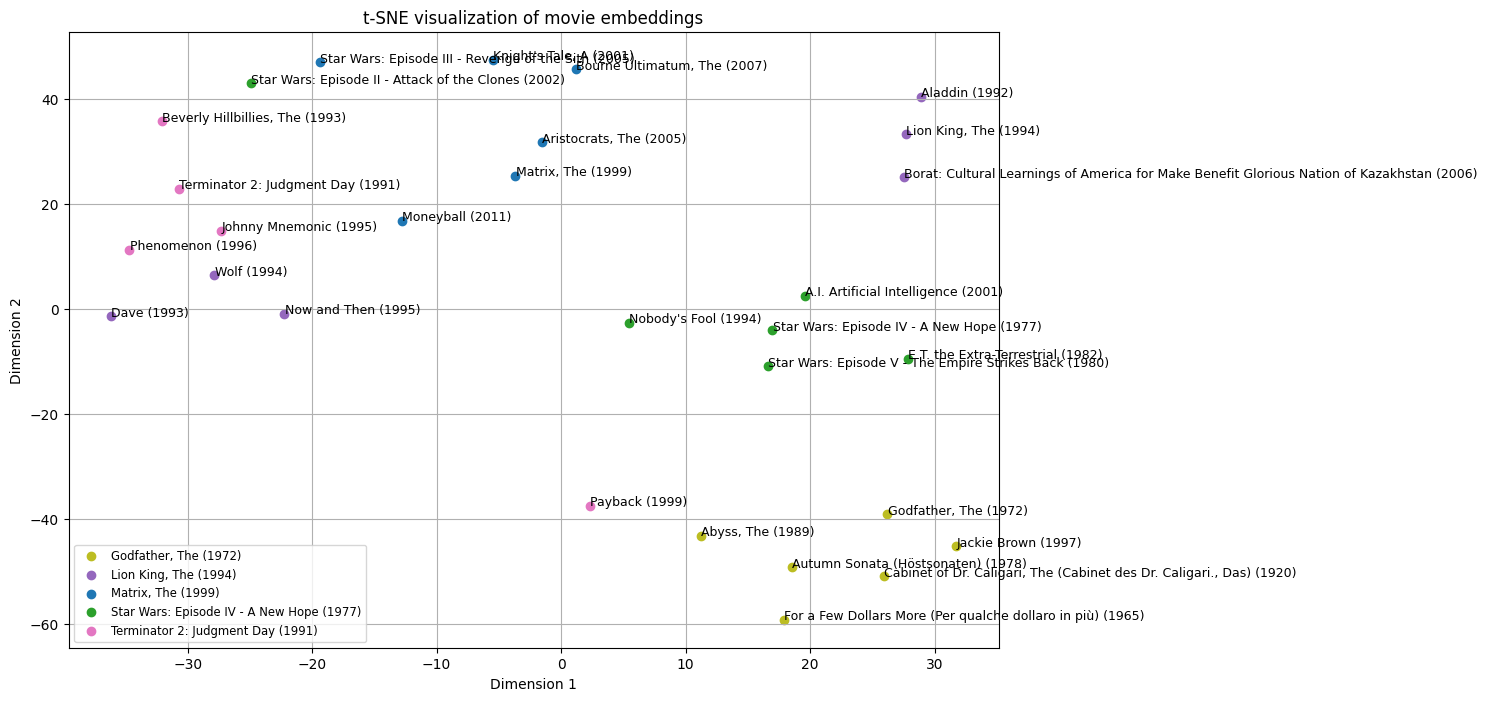

In [ ]:
################################ t-SNE #########################################

# Get the embeddings for the movies of interest (query movies + similar movies)
movies_of_interest = list(query_embeddings.keys()) + [movie for similar in most_similar_movies.values() for movie in similar]
embeddings_of_interest = np.array([get_embedding_by_title(movie) for movie in movies_of_interest])

# Ensure there are no duplicate movies
movies_of_interest, idx = np.unique(movies_of_interest, return_index=True)
embeddings_of_interest = embeddings_of_interest[idx]

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Adjusted perplexity
reduced_embeddings = tsne.fit_transform(embeddings_of_interest)

# Create a DataFrame for visualization
embedding_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
embedding_df['title'] = movies_of_interest

# Assign colors to each similarity group
color_map = plt.get_cmap('tab10')
color_assignment = {}
group_counter = 0

for query in query_movies:
    color_assignment[query] = group_counter
    for similar_movie in most_similar_movies[query]:
        if similar_movie not in color_assignment:
            color_assignment[similar_movie] = group_counter
    group_counter += 1

# Add color information to the DataFrame
embedding_df['color'] = embedding_df['title'].map(color_assignment)

# Plot the embeddings with colors based on similarity groups
plt.figure(figsize=(12, 8))
for i, row in embedding_df.iterrows():
    plt.scatter(row['x'], row['y'], marker='o', color=color_map(row['color'] / group_counter), label=row['title'] if row['title'] in query_movies else "")
    plt.text(row['x'] + 0.02, row['y'] + 0.02, row['title'], fontsize=9)

# Create a custom legend for the query movies
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("t-SNE visualization of movie embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


### Comparison of paths

In this section, we compute the shortest path between each query movie and a number $k$ of:

- random neighbours
- random nodes in the graph
- outputs of the model (k-top ones)

The shortest path makes use of the weights of the edges and it's computed with the A* algorithm. To compute it we needed to convert the weights to their reciprocal in such a way that the best path is the one with the highest real weights with the fewer steps.

In the final plots we show the median value of the shortest path costs for each query movie.

In [ ]:
# return the top 5 prediction of either model 1 or model 2
def prediction(node, contexts=False):
    input = get_movie_id_by_title(node)
    input = vocabulary_lookup[input]
    input = np.eye(len(vocabulary_lookup))[input]
    input = torch.tensor(input,dtype=torch.float32)
    input = input.to(device)

    if contexts:
        neighbors = list(movies_graph.neighbors(get_movie_id_by_title(node)))
        neighbors = random.sample(neighbors, window_size)

        neighbors = [vocabulary_lookup[movie_id] for movie_id in neighbors]
        neighbors = np.array(neighbors)

        context = np.eye(len(vocabulary_lookup))[neighbors] # warning: to simplify the computations, we define the contexts as random neighbors
        context = torch.tensor(context, dtype=torch.float32)
        context = context.to(device)

        output = model2(input, context.unsqueeze(dim=0))
        output=output.detach().cpu().numpy().flatten()
        best_nodes= np.argsort(output)[-50:]

        return best_nodes+1

    else :
        output = model1(input)
        output = output.detach().cpu().numpy()
        best_nodes = np.argsort(output)[-50:]

        #print(best_nodes)

        return best_nodes+1

In [ ]:
# New graph with reciprocal weights
G_transformed = nx.Graph()  # For undirected graph

# Add nodes
G_transformed.add_nodes_from(movies_graph.nodes())

# Add transformed edges
for u, v, data in movies_graph.edges(data=True):
    original_weight = data['weight']
    transformed_weight = 1 / original_weight  # Take the reciprocal
    G_transformed.add_edge(u, v, weight=transformed_weight)

k = 50 # number of similar movies

shortest_path_1 = []
shortest_path_2 = []
shortest_path_3 = []
shortest_path_4 = []

for query in query_movies:
    shortest_path_lengths1 = []
    shortest_path_lengths2 = []
    shortest_path_lengths3 = []
    shortest_path_lengths4 = []

    for similar_movie in prediction(query): # what the model1 suggests
        shortest_path_lengths1.append(nx.astar_path_length(G_transformed, vocabulary[similar_movie], get_movie_id_by_title(query), weight='weight'))

    for similar_movie in prediction(query, contexts=True): # what the model2 suggests
        shortest_path_lengths2.append(nx.astar_path_length(G_transformed, vocabulary[similar_movie], get_movie_id_by_title(query), weight='weight'))

    for similar_movie in list(nx.neighbors(movies_graph, get_movie_id_by_title(query)))[:k]: # neighbors
        shortest_path_lengths3.append(nx.astar_path_length(G_transformed, similar_movie, get_movie_id_by_title(query), weight='weight'))

    all_nodes = list(G_transformed.nodes())
    random_movies = []

    while len(random_movies) < 100:
        random_movie_node_id = random.choice(all_nodes)

        if nx.has_path(G_transformed, random_movie_node_id, get_movie_id_by_title(query)):
            random_movies.append(random_movie_node_id)

    for random_movie_node_id in list(random_movies)[:k]:
        shortest_path_lengths4.append(nx.astar_path_length(G_transformed, random_movie_node_id, get_movie_id_by_title(query),  weight='weight'))

    shortest_path_1.append(shortest_path_lengths1)
    shortest_path_2.append(shortest_path_lengths2)
    shortest_path_3.append(shortest_path_lengths3)
    shortest_path_4.append(shortest_path_lengths4)

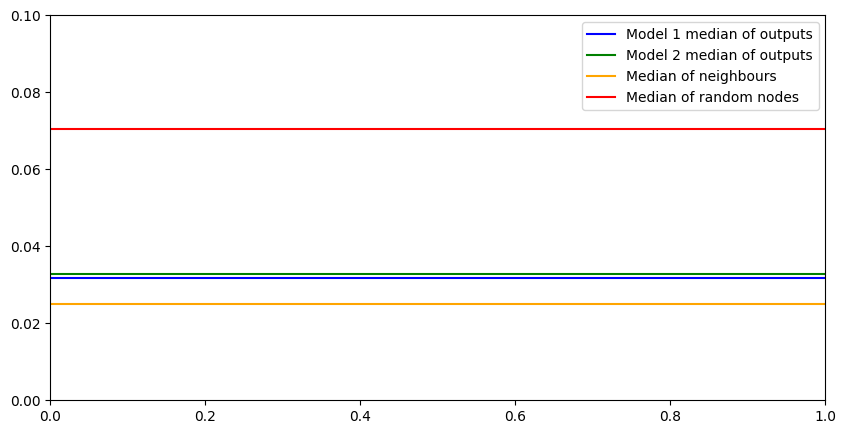

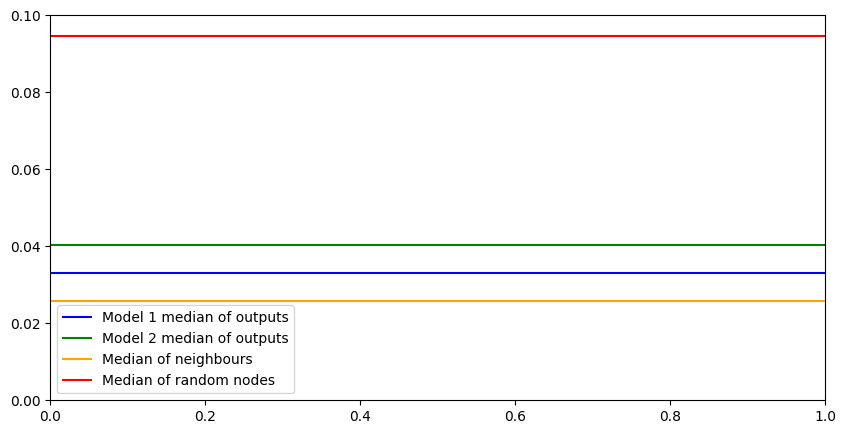

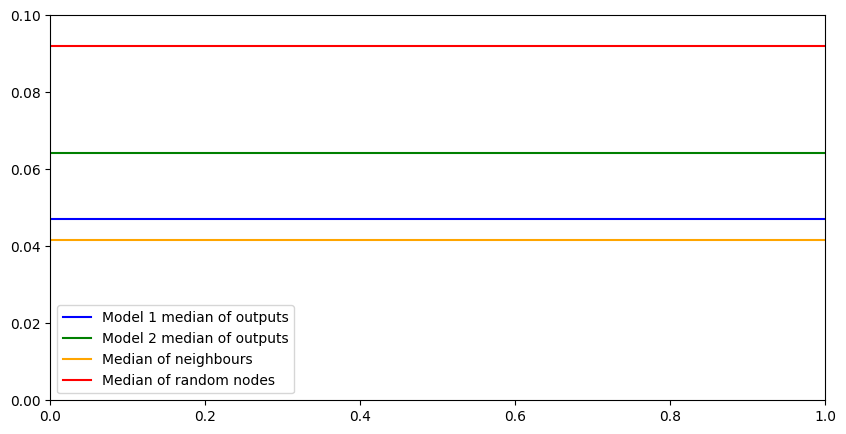

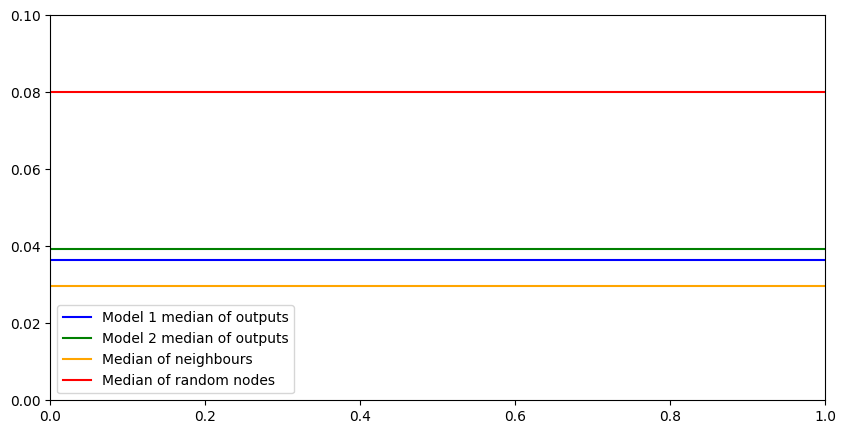

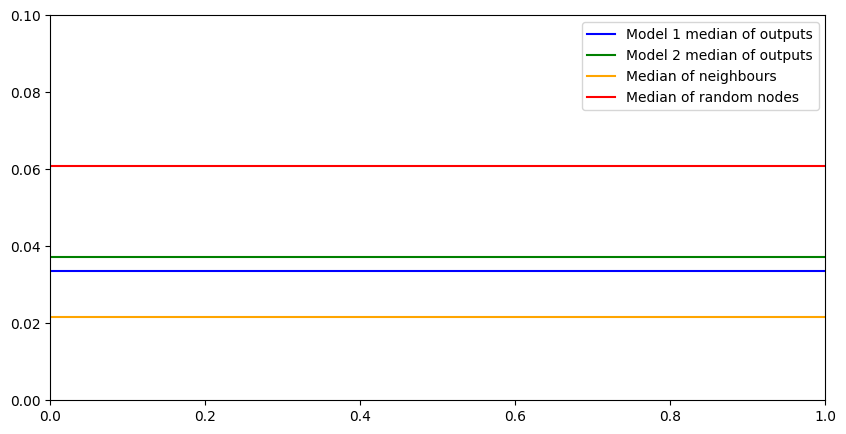

In [ ]:
for i in range(5): # to show mean, de-comment lines

    median1 = np.median(shortest_path_1[i])
    median2 = np.median(shortest_path_2[i])
    median3 = np.median(shortest_path_3[i])
    median4 = np.median(shortest_path_4[i])

    # mean1 = np.mean(shortest_path_1[i])
    # mean2 = np.mean(shortest_path_2[i])
    # mean3 = np.mean(shortest_path_3[i])
    # mean4 = np.mean(shortest_path_4[i])

    plt.figure(figsize=(10, 5))

    plt.axhline(y=median1, color='blue', linestyle='-', label='Model 1 median of outputs')
    plt.axhline(y=median2, color='green', linestyle='-', label='Model 2 median of outputs')
    plt.axhline(y=median3, color='orange', linestyle='-', label='Median of neighbours')
    plt.axhline(y=median4, color='red', linestyle='-', label='Median of random nodes')

    # plt.axhline(y=mean1, color='blue', linestyle='--', alpha=0.3, label='Model 1 mean of outputs')
    # plt.axhline(y=mean2, color='green', linestyle='--', alpha=0.3, label='Model 2 mean of outputs')
    # plt.axhline(y=mean3, color='orange', linestyle='--', alpha=0.3, label='Mean of neighbours')
    # plt.axhline(y=mean4, color='red', linestyle='--', alpha=0.3, label='Mean of random nodes')

    plt.ylim(0, 0.1)
    plt.legend()

    plt.show()

Clearly, our two models are better then choosing random nodes from the graph, and the cost of the shortest path, in some cases, is very near to the cost of the shortest path taking into account the neighbours of the query movies.

The shortest path seems to be a good metric able to partially intepret our model. Rightfully, the output of the models are not the neighbours of the input (and this cleary depicted by the plot above) because our model is not meant to ***just*** find the shortest path but all the relations between nodes within the graph.